Copyright (C) 2018 Pierluigi Ferrari

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
    http://www.apache.org/licenses/LICENSE-2.0
 Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [1]:
import h5py
import numpy as np
import shutil

from misc_utils.tensor_sampling_utils import sample_tensors

In [2]:
# TODO: Set the path for the source weights file you want to load.
# 이 부분은 경로를 직접 입력해야 함
weights_source_path = 'C:\\Users\\user\\Desktop\\weight\\VGG_VOC0712Plus_SSD_300x300_iter_240000.h5'

# TODO: Set the path and name for the destination weights file
#       that you want to create.
# 이 부분은 경로를 직접 입력해야 함
weights_destination_path = 'C:\\Users\\user\\Desktop\\weight\\VGG_VOC0712Plus_SSD_300x300_iter_240000_sampling_2_.h5'

# Make a copy of the weights file.
shutil.copy(weights_source_path, weights_destination_path)

'C:\\Users\\user\\Desktop\\weight\\VGG_VOC0712Plus_SSD_300x300_iter_240000_sampling_2_.h5'

In [3]:
# Load both the source weights file and the copy we made.
# We will load the original weights file in read-only mode so that we can't mess up anything.
weights_source_file = h5py.File(weights_source_path, 'r')
weights_destination_file = h5py.File(weights_destination_path)

In [4]:
classifier_names = ['conv4_3_norm_mbox_conf',
                    'fc7_mbox_conf',
                    'conv6_2_mbox_conf',
                    'conv7_2_mbox_conf',
                    'conv8_2_mbox_conf',
                    'conv9_2_mbox_conf']

In [5]:
# 이 부분은 class 개수대로 모델이 알맞게 설계 된 건지 체크하는 영역
# 넘어가도 됨

conv4_3_norm_mbox_conf_kernel = weights_destination_file[classifier_names[0]][classifier_names[0]]['kernel:0']
conv4_3_norm_mbox_conf_bias = weights_destination_file[classifier_names[0]][classifier_names[0]]['bias:0']

print("Shape of the '{}' weights:".format(classifier_names[0]))
print()
print("kernel:\t", conv4_3_norm_mbox_conf_kernel.shape)
print("bias:\t", conv4_3_norm_mbox_conf_bias.shape)

Shape of the 'conv4_3_norm_mbox_conf' weights:

kernel:	 (3, 3, 512, 84)
bias:	 (84,)


In [6]:
# TODO: Set the number of classes in the source weights file. Note that this number must include
#       the background class, so for MS COCO's 80 classes, this must be 80 + 1 = 81.
#       PASCAL VOC를 사용했으므로 20 + 1 = 21.
n_classes_source = 21
# TODO: Set the indices of the classes that you want to pick for the sub-sampled weight tensors.
#       In case you would like to just randomly sample a certain number of classes, you can just set
#       `classes_of_interest` to an integer instead of the list below. Either way, don't forget to
#       include the background class. That is, if you set an integer, and you want `n` positive classes,
#       then you must set `classes_of_interest = n + 1`.
# class 구분은 crack or background이므로 총 2개임
classes_of_interest = 2

# classes_of_interest = 9 # Uncomment this in case you want to just randomly sub-sample the last axis instead of providing a list of indices.

for name in classifier_names:
    # Get the trained weights for this layer from the source HDF5 weights file.
    kernel = weights_source_file[name][name]['kernel:0'].value
    bias = weights_source_file[name][name]['bias:0'].value

    # Get the shape of the kernel. We're interested in sub-sampling
    # the last dimension, 'o'.
    height, width, in_channels, out_channels = kernel.shape
    
    # Compute the indices of the elements we want to sub-sample.
    # Keep in mind that each classification predictor layer predicts multiple
    # bounding boxes for every spatial location, so we want to sub-sample
    # the relevant classes for each of these boxes.
    if isinstance(classes_of_interest, (list, tuple)):
        subsampling_indices = []
        for i in range(int(out_channels/n_classes_source)):
            indices = np.array(classes_of_interest) + i * n_classes_source
            subsampling_indices.append(indices)
        subsampling_indices = list(np.concatenate(subsampling_indices))
    elif isinstance(classes_of_interest, int):
        subsampling_indices = int(classes_of_interest * (out_channels/n_classes_source))
    else:
        raise ValueError("`classes_of_interest` must be either an integer or a list/tuple.")
    
    # Sub-sample the kernel and bias.
    # The `sample_tensors()` function used below provides extensive
    # documentation, so don't hesitate to read it if you want to know
    # what exactly is going on here.
    # 이 수치들을 수정했을 때 성능에 차이가 있으려나? 한 번 알아보자
    new_kernel, new_bias = sample_tensors(weights_list=[kernel, bias],
                                          sampling_instructions=[height, width, in_channels, subsampling_indices],
                                          axes=[[3]], # The one bias dimension corresponds to the last kernel dimension.
                                          init=['gaussian', 'zeros'],
                                          mean=0.0,
                                          stddev=0.005)
    
    # Delete the old weights from the destination file.
    del weights_destination_file[name][name]['kernel:0']
    del weights_destination_file[name][name]['bias:0']
    # Create new datasets for the sub-sampled weights.
    weights_destination_file[name][name].create_dataset(name='kernel:0', data=new_kernel)
    weights_destination_file[name][name].create_dataset(name='bias:0', data=new_bias)

# Make sure all data is written to our output file before this sub-routine exits.
weights_destination_file.flush()

In [7]:
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

%matplotlib inline

Using TensorFlow backend.


In [8]:
img_height = 300 # Height of the model input images
img_width = 300 # Width of the model input images
img_channels = 3 # Number of color channels of the model input images
mean_color = [123, 117, 104] # The per-channel mean of the images in the dataset. Do not change this value if you're using any of the pre-trained weights.
swap_channels = [2, 1, 0] # The color channel order in the original SSD is BGR, so we'll have the model reverse the color channel order of the input images.
n_classes = 1 # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO
              # 여기서는 background class를 제외한 순수 interesting class의 갯수를 의미.
scales_pascal = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05] # The anchor box scaling factors used in the original SSD300 for the Pascal VOC datasets
scales_coco = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05] # The anchor box scaling factors used in the original SSD300 for the MS COCO datasets
scales = scales_pascal
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD300; the order matters
two_boxes_for_ar1 = True
steps = [8, 16, 32, 64, 100, 300] # The space between two adjacent anchor box center points for each predictor layer.
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are divided as in the original implementation
normalize_coords = True

In [9]:
# 1: Build the Keras model.

K.clear_session() # Clear previous models from memory.

model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                l2_regularization=0.0005,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                swap_channels=swap_channels)

# 2: Load some weights into the model.

# TODO: Set the path to the weights you want to load.
weights_path = weights_destination_path

model.load_weights(weights_path, by_name=True)

# 3: Instantiate an optimizer and the SSD loss function and compile the model.
#    If you want to follow the original Caffe implementation, use the preset SGD
#    optimizer, otherwise I'd recommend the commented-out Adam optimizer.

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#sgd = SGD(lr=0.001, momentum=0.9, decay=0.0, nesterov=False)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

In [10]:
# 1: Instantiate two `DataGenerator` objects: One for training, one for validation.

# Optional: If you have enough memory, consider loading the images into memory for the reasons explained above.
# 속도 향상을 위해 True로 변경하였음. RAM이 받쳐주지 못한다면 False로 바꿀 것.
train_dataset = DataGenerator(load_images_into_memory=True, hdf5_dataset_path=None)
val_dataset = DataGenerator(load_images_into_memory=True, hdf5_dataset_path=None)

# 2: Parse the image and label lists for the training and validation datasets. This can take a while.

# TODO: Set the paths to the datasets here.

# The directories that contain the images.
# 추후 Crack images 및 annotations를 augmentation 할 것
Crack_images_dir      = '../../Desktop/SPARK/Concrete Crack Images for Classification/Positive 300 X 300/Positive/'
#Noncrack_images_dir   = '../../Desktop/SPARK/Concrete Crack Images for Classification/Negative 300 X 300/Negative/'

# The directories that contain the annotations.
Crack_images_dir_annotations      = '../../Desktop/SPARK/Concrete Crack Images for Classification/Positive 300 X 300/annotation/'
#Noncrack_images_dir_annotations   = '../../Desktop/SPARK/Concrete Crack Images for Classification/Negative 300 X 300/annotation/'

# The paths to the image sets.
# 여기서 train/val/test 세트로 나눠야 함
# trainval:test의 비중을 4:1로 나눔 -> trainval인걸 보니 train 세트 내에서 자동으로 validation을 랜덤으로 진행하겠다는 건가?
# 추후 trainval/test를 랜덤하게 나눌 것

#VOC_2012_train_image_set_filename    = '../../datasets/VOCdevkit/VOC2012/ImageSets/Main/train.txt'
#VOC_2012_val_image_set_filename      = '../../datasets/VOCdevkit/VOC2012/ImageSets/Main/val.txt'

trainval_image_set_filename_crack = '../../Desktop/SPARK/Concrete Crack Images for Classification/Positive 300 X 300/trainval.txt'
#trainval_image_set_filename_noncrack = '../../Desktop/SPARK/Concrete Crack Images for Classification/Negative 300 X 300/trainval.txt'
test_image_set_filename_crack     = '../../Desktop/SPARK/Concrete Crack Images for Classification/Positive 300 X 300/test.txt'
#test_image_set_filename_noncrack     = '../../Desktop/SPARK/Concrete Crack Images for Classification/Negative 300 X 300/test.txt'

# The XML parser needs to now what object class names to look for and in which order to map them to integers.
# 나는 1개의 클래스를 사용
# non-crack을 annotation할 수는 없음. non-crack은 background class로 처리되어야 하는 게 맞음. 
# 추후 test에서 non-crack이미지도 함께 테스트 하면 됨
# 하지만 background class는 default로 여기 포함시켜야 함
classes = ['background','crack']

train_dataset.parse_xml(images_dirs=[Crack_images_dir],
                        image_set_filenames=[trainval_image_set_filename_crack],
                        annotations_dirs=[Crack_images_dir_annotations],
                        classes=classes,
                        include_classes='all',
                        exclude_truncated=False,
                        exclude_difficult=False,
                        ret=False)

val_dataset.parse_xml(images_dirs=[Crack_images_dir],
                      image_set_filenames=[test_image_set_filename_crack],
                      annotations_dirs=[Crack_images_dir_annotations],
                      classes=classes,
                      include_classes='all',
                      exclude_truncated=False,
                      exclude_difficult=True,
                      ret=False)

# Optional: Convert the dataset into an HDF5 dataset. This will require more disk space, but will
# speed up the training. Doing this is not relevant in case you activated the `load_images_into_memory`
# option in the constructor, because in that cas the images are in memory already anyway. If you don't
# want to create HDF5 datasets, comment out the subsequent two function calls.
# 나는 load_images_into_memory=True 체크 하였으므로 아래 함수는 comment out 시킴.

#train_dataset.create_hdf5_dataset(file_path='dataset_pascal_voc_07+12_trainval.h5',
#                                  resize=False,
#                                  variable_image_size=True,
#                                  verbose=True)

#val_dataset.create_hdf5_dataset(file_path='dataset_pascal_voc_07_test.h5',
#                                resize=False,
#                                variable_image_size=True,
#                                verbose=True)

Loading images into memory: 100%|█████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 379.25it/s]


In [11]:
# 3: Set the batch size.

batch_size = 2 # Change the batch size if you like, or if you run into GPU memory issues.
               # 16 -> 4로 줄임
               # 8을 넣었을 땐 에러가 났었음, 추후 다시 시도해 볼 것
               # RAM 16GB, GTX970M 기준임 
               # AWS를 이용할 땐 그에 맞게 늘릴 것
              

# 4: Set the image transformations for pre-processing and data augmentation options.

# For the training generator:
ssd_data_augmentation = SSDDataAugmentation(img_height=img_height,
                                            img_width=img_width,
                                            background=mean_color)

# For the validation generator:
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)

# 5: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.

# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.
# layer를 과제에 맞게 수정해야 하는 곳
# 추후 각자 공부한 내용을 바탕으로 layer를 수정해가며 어떤 시도가 가장 loss 값을 줄여주는 지 알아보자 
predictor_sizes = [model.get_layer('conv4_3_norm_mbox_conf').output_shape[1:3],
                   model.get_layer('fc7_mbox_conf').output_shape[1:3],
                   model.get_layer('conv6_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv7_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv8_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv9_2_mbox_conf').output_shape[1:3]]

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_per_layer=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.5,
                                    normalize_coords=normalize_coords)

# 6: Create the generator handles that will be passed to Keras' `fit_generator()` function.

train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,  # 이미지들의 train 순서를 random하게 해주는 기능 맞는지 확인
                                         transformations=[ssd_data_augmentation],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[convert_to_3_channels,
                                                      resize],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Number of images in the training dataset:	  8000
Number of images in the validation dataset:	  2000


In [30]:
# Define a learning rate schedule.
# epoch = 1,000 training steps
# 알맞은 Learning rate를 찾을 것
def lr_schedule(epoch):
    if epoch < 10:           
        return 0.0005      
    else:
        return 0.000005

In [31]:
# Define model callbacks.

# TODO: Set the filepath under which you want to save the model.
# 추후 file path를 알맞게 수정하자
# 원래 여기서 return하는 파일은 weight가 아니라 model이다!
### 하지만 inference의 편의를 위해 여기서 Weight 만 저장하는 것으로 바꿈!!!
### 여기서 Model을 통째로 저장하면 Inference에서 굉장한 어려움을 겪음!!!
model_checkpoint = ModelCheckpoint(filepath='ssd300_pascal_07+12_epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=True, ### 여기서 Weight 만 저장하는 것으로 바꿈!!!
                                   mode='auto',
                                   period=1)
#model_checkpoint.best = 

csv_logger = CSVLogger(filename='ssd300_pascal_07+12_training_log.csv',
                       separator=',',
                       append=True)

learning_rate_scheduler = LearningRateScheduler(schedule=lr_schedule,
                                                verbose=1)

terminate_on_nan = TerminateOnNaN()

callbacks = [model_checkpoint,
             csv_logger,
             learning_rate_scheduler,
             terminate_on_nan]

In [32]:
# If you're resuming a previous training, set `initial_epoch` and `final_epoch` accordingly.
# 추후 최적화를 위해 이 부분을 수정해야 함
# 데이터의 갯수에 따라서도 각 epoch 변수를 수정해야 함
initial_epoch   = 0
final_epoch     = 16
steps_per_epoch = 1000

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=final_epoch,
                              callbacks=callbacks,
                              validation_data=val_generator,
                              validation_steps=ceil(val_dataset_size/batch_size),
                              initial_epoch=initial_epoch)

Epoch 1/16

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0005.
 311/1000 [========>.....................] - ETA: 4:59 - loss: 2.623 - ETA: 4:47 - loss: 3.185 - ETA: 4:43 - loss: 4.404 - ETA: 4:46 - loss: 4.634 - ETA: 4:43 - loss: 4.555 - ETA: 4:41 - loss: 4.719 - ETA: 4:40 - loss: 4.987 - ETA: 4:37 - loss: 4.997 - ETA: 4:38 - loss: 4.811 - ETA: 4:37 - loss: 4.718 - ETA: 4:35 - loss: 4.723 - ETA: 4:36 - loss: 4.634 - ETA: 4:35 - loss: 4.544 - ETA: 4:34 - loss: 4.422 - ETA: 4:34 - loss: 4.330 - ETA: 4:34 - loss: 4.312 - ETA: 4:33 - loss: 4.263 - ETA: 4:32 - loss: 4.260 - ETA: 4:33 - loss: 4.226 - ETA: 4:32 - loss: 4.161 - ETA: 4:32 - loss: 4.074 - ETA: 4:31 - loss: 4.037 - ETA: 4:30 - loss: 3.994 - ETA: 4:30 - loss: 3.975 - ETA: 4:30 - loss: 3.983 - ETA: 4:30 - loss: 3.943 - ETA: 4:29 - loss: 3.982 - ETA: 4:29 - loss: 3.911 - ETA: 4:29 - loss: 3.937 - ETA: 4:28 - loss: 3.903 - ETA: 4:28 - loss: 3.858 - ETA: 4:28 - loss: 3.884 - ETA: 4:27 - loss: 3.928 - ETA: 4:27 - loss

 314/1000 [========>.....................] - ETA: 4:39 - loss: 4.800 - ETA: 4:37 - loss: 5.441 - ETA: 4:36 - loss: 5.075 - ETA: 4:35 - loss: 4.644 - ETA: 4:32 - loss: 4.157 - ETA: 4:34 - loss: 4.037 - ETA: 4:34 - loss: 3.814 - ETA: 4:34 - loss: 3.770 - ETA: 4:34 - loss: 3.741 - ETA: 4:32 - loss: 3.691 - ETA: 4:32 - loss: 3.617 - ETA: 4:34 - loss: 3.482 - ETA: 4:33 - loss: 3.464 - ETA: 4:33 - loss: 3.388 - ETA: 4:33 - loss: 3.345 - ETA: 4:32 - loss: 3.285 - ETA: 4:31 - loss: 3.311 - ETA: 4:32 - loss: 3.344 - ETA: 4:31 - loss: 3.333 - ETA: 4:31 - loss: 3.377 - ETA: 4:31 - loss: 3.305 - ETA: 4:31 - loss: 3.290 - ETA: 4:30 - loss: 3.320 - ETA: 4:30 - loss: 3.359 - ETA: 4:30 - loss: 3.435 - ETA: 4:30 - loss: 3.386 - ETA: 4:30 - loss: 3.426 - ETA: 4:30 - loss: 3.506 - ETA: 4:29 - loss: 3.467 - ETA: 4:29 - loss: 3.463 - ETA: 4:29 - loss: 3.490 - ETA: 4:28 - loss: 3.450 - ETA: 4:28 - loss: 3.419 - ETA: 4:28 - loss: 3.470 - ETA: 4:28 - loss: 3.463 - ETA: 4:27 - loss: 3.436 - ETA: 4:27 - loss: 3

1000/1000 [==============================] - ETA: 14s - loss: 3.47 - ETA: 14s - loss: 3.47 - ETA: 14s - loss: 3.48 - ETA: 13s - loss: 3.47 - ETA: 13s - loss: 3.47 - ETA: 13s - loss: 3.47 - ETA: 12s - loss: 3.47 - ETA: 12s - loss: 3.47 - ETA: 12s - loss: 3.47 - ETA: 11s - loss: 3.47 - ETA: 11s - loss: 3.47 - ETA: 11s - loss: 3.47 - ETA: 11s - loss: 3.47 - ETA: 10s - loss: 3.47 - ETA: 10s - loss: 3.47 - ETA: 10s - loss: 3.47 - ETA: 9s - loss: 3.4721 - ETA: 9s - loss: 3.471 - ETA: 9s - loss: 3.469 - ETA: 8s - loss: 3.468 - ETA: 8s - loss: 3.468 - ETA: 8s - loss: 3.467 - ETA: 7s - loss: 3.466 - ETA: 7s - loss: 3.465 - ETA: 7s - loss: 3.464 - ETA: 6s - loss: 3.464 - ETA: 6s - loss: 3.463 - ETA: 6s - loss: 3.464 - ETA: 5s - loss: 3.463 - ETA: 5s - loss: 3.463 - ETA: 5s - loss: 3.462 - ETA: 5s - loss: 3.460 - ETA: 4s - loss: 3.461 - ETA: 4s - loss: 3.459 - ETA: 4s - loss: 3.459 - ETA: 3s - loss: 3.458 - ETA: 3s - loss: 3.458 - ETA: 3s - loss: 3.457 - ETA: 2s - loss: 3.459 - ETA: 2s - loss: 3.

 414/1000 [===========>..................] - ETA: 4:40 - loss: 2.636 - ETA: 4:32 - loss: 3.454 - ETA: 4:35 - loss: 3.739 - ETA: 4:34 - loss: 3.658 - ETA: 4:35 - loss: 3.539 - ETA: 4:33 - loss: 3.442 - ETA: 4:34 - loss: 3.385 - ETA: 4:33 - loss: 3.296 - ETA: 4:33 - loss: 3.153 - ETA: 4:32 - loss: 3.322 - ETA: 4:32 - loss: 3.153 - ETA: 4:32 - loss: 3.250 - ETA: 4:32 - loss: 3.332 - ETA: 4:32 - loss: 3.321 - ETA: 4:30 - loss: 3.353 - ETA: 4:31 - loss: 3.299 - ETA: 4:31 - loss: 3.218 - ETA: 4:30 - loss: 3.156 - ETA: 4:30 - loss: 3.077 - ETA: 4:30 - loss: 3.083 - ETA: 4:29 - loss: 3.075 - ETA: 4:29 - loss: 3.093 - ETA: 4:29 - loss: 3.155 - ETA: 4:28 - loss: 3.137 - ETA: 4:28 - loss: 3.129 - ETA: 4:28 - loss: 3.056 - ETA: 4:28 - loss: 3.010 - ETA: 4:27 - loss: 2.973 - ETA: 4:27 - loss: 2.967 - ETA: 4:27 - loss: 3.083 - ETA: 4:26 - loss: 3.319 - ETA: 4:26 - loss: 3.301 - ETA: 4:26 - loss: 3.334 - ETA: 4:26 - loss: 3.343 - ETA: 4:25 - loss: 3.354 - ETA: 4:25 - loss: 3.313 - ETA: 4:25 - loss: 3

KeyboardInterrupt: 

In [95]:
# 1: Set the generator for the predictions.
# batch_size는 원래 1
predict_generator = val_dataset.generate(batch_size=1,
                                         shuffle=True,
                                         transformations=[convert_to_3_channels,
                                                          resize],
                                         label_encoder=None,
                                         returns={'processed_images',
                                                  'filenames',
                                                  'inverse_transform',
                                                  'original_images',
                                                  'original_labels'},
                                         keep_images_without_gt=False)

In [96]:
# 2: Generate samples.

batch_images, batch_filenames, batch_inverse_transforms, batch_original_images, batch_original_labels = next(predict_generator)

i = 0 # Which batch item to look at

print("Image:", batch_filenames[i])
print()
print("Ground truth boxes:\n")
print(np.array(batch_original_labels[i]))

Image: ../../Desktop/SPARK/Concrete Crack Images for Classification/Positive 300 X 300/Positive/013772.jpg

Ground truth boxes:

[[  1 156   1 238 300]]


In [97]:
# 3: Make predictions.

y_pred = model.predict(batch_images)

In [98]:
# 4: Decode the raw predictions in `y_pred`.

y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.5,
                                   iou_threshold=0.4,
                                   top_k=200,
                                   normalize_coords=normalize_coords,
                                   img_height=img_height,
                                   img_width=img_width)

In [99]:
# 5: Convert the predictions for the original image.

y_pred_decoded_inv = apply_inverse_transforms(y_pred_decoded, batch_inverse_transforms)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_decoded_inv[i])

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  1.     0.69 155.    -2.   264.   298.  ]]


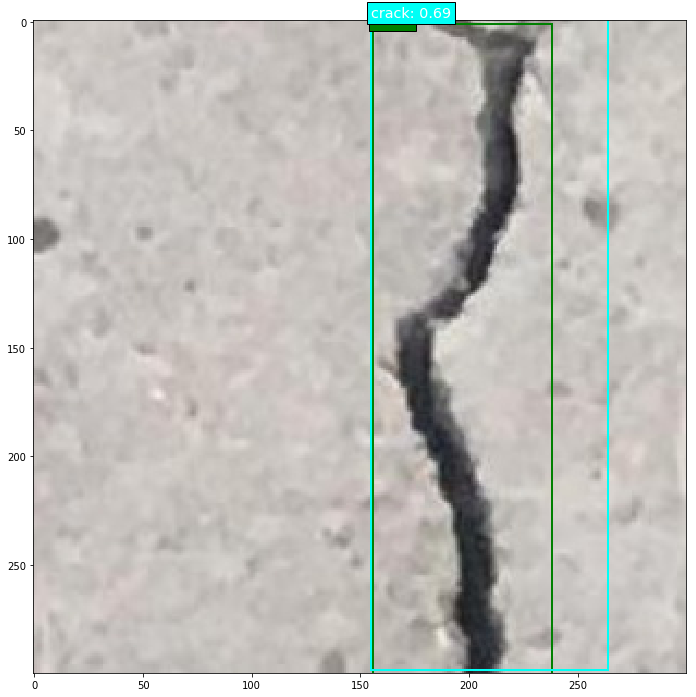

In [100]:
# 5: Draw the predicted boxes onto the image

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist()
classes = ['background','crack','noncrack']

plt.figure(figsize=(20,12))
plt.imshow(batch_original_images[i])

current_axis = plt.gca()

for box in batch_original_labels[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

for box in y_pred_decoded_inv[i]:
    xmin = box[2]
    ymin = box[3]
    xmax = box[4]
    ymax = box[5]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

In [14]:
import time
import matplotlib
import matplotlib.pyplot as plt
import cv2
from skimage import io
from skimage import data
from skimage.color import rgb2gray
from skimage.data import page
from skimage.filters import (threshold_sauvola)
from PIL import Image

img_path = 'C:\\Users\\user\\Desktop\\testdata\\7.jpg'
img = cv2.imread(img_path)
img_gray = rgb2gray(img)

    # window size와 k값은 'Concrete Crack Identification Using a UAV Incorporating Hybrid Image Processing' 논문이 제시한 값을
    # 그대로 사용하였습니다.
    
    # window size and k value were used without any changes from the
    # 'Concrete Crack Identification Using a UAV Incorporating Hybrid Image Processing' thesis.
window_size_Pw = 71
thresh_sauvola_Pw = threshold_sauvola(img_gray, window_size=window_size_Pw, k=0.42)

binary_sauvola_Pw = img_gray > thresh_sauvola_Pw
binary_sauvola_Pw_bw = img_gray > thresh_sauvola_Pw

binary_sauvola_Pw_bw.dtype = 'uint8'

binary_sauvola_Pw_bw *= 255
cv2.imwrite("C:\\Users\\user\Desktop\\33.jpg", binary_sauvola_Pw_bw)

c:\users\user\anaconda2\envs\tensorflow-gpu\lib\site-packages\skimage\util\arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]


True

In [15]:
from skimage.morphology import skeletonize
from skimage.util import invert

img_Pw = invert(binary_sauvola_Pw)

skeleton_frames_Pw = skeletonize(img_Pw)

skeleton_frames_Pw.dtype = 'uint8'

skeleton_frames_Pw *= 255

cv2.imwrite("C:\\Users\\user\Desktop\\33_1.jpg", skeleton_Pw) 

True

In [16]:
import numpy as np
from scipy import ndimage as ndi
from skimage import feature

edges_frames_Pw = feature.canny(binary_sauvola_Pw, 0.09)

edges_frames_Pw.dtype = 'uint8'

edges_frames_Pw *= 255
    
cv2.imwrite("C:\\Users\\user\Desktop\\33_2.jpg", edges_Pw) 

True

In [18]:
# 7. 균열의 폭을 계산합니다. 
# 1) 균열의 Skeleton으로부터 균열의 진행 방향을 파악합니다.
# 2) 균열의 진행 방향에 수직인 직선을 긋습니다.
# 3) 이 수직선과 균열의 Edge가 만나는데, 이 거리가 곧 균열의 폭입니다.

# 7. Calculate the width of the crack.
# 1) Analyze the direction of the crack from the skeleton.
# 2) Draw a perpendicular line of the direction
# 3) The perpendicular line meets the edge. This distance is the width of the crack.

import queue
import math

dx_dir_right = [-5,-5,-5,-4,-3,-2,-1,0,1,2,3,4,5,5]
dy_dir_right = [0,1,2,3,4,5,5,5,5,5,4,3,2,1]

dx_dir_left = [5,5,5,4,3,2,1,0,-1,-2,-3,-4,-5,-5]
dy_dir_left = [0,-1,-2,-3,-4,-5,-5,-5,-5,-5,-4,-3,-2,-1]

dx_bfs = [-1,-1,0,1,1,1,0,-1]
dy_bfs = [0,1,1,1,0,-1,-1,-1]

save_result = []

# BFS를 통해 Skeleton을 찾습니다.
# Searching the skeleton through BFS.

start = [0,0]
next = []
q = queue.Queue()
q.put(start)

len_x = skeleton_frames_Pw.shape[0]
len_y = skeleton_frames_Pw.shape[1]

visit = np.zeros((len_x,len_y))
crack_width_list = []

while(q.empty() == 0):
    next = q.get()
    x = next[0]
    y = next[1]
    right_x = right_y = left_x = left_y = -1

    if(skeleton_frames_Pw[x][y] == 255):
            # Skeleton을 바탕으로 균열의 진행 방향을 구합니다.
            # Estimating the direction of the crack from skeleton
        for i in range(0, len(dx_dir_right)):
            right_x = x + dx_dir_right[i]
            right_y = y + dy_dir_right[i]
            if(right_x<0 or right_y<0 or right_x>=len_x or right_y>=len_y): 
                right_x = right_y = -1
                continue;
            if(skeleton_frames_Pw[right_x][right_y] == 255): break;
            if(i==13): right_x = right_y = -1

        if(right_x == -1): 
            right_x = x
            right_y = y

        for i in range(0, len(dx_dir_left)):
            left_x = x + dx_dir_left[i]
            left_y = y + dy_dir_left[i]
            if(left_x <0 or left_y<0 or left_x >=len_x or left_y>=len_y): 
                left_x = left_y = -1
                continue;
            if(skeleton_frames_Pw[left_x][left_y] == 255): break;
            if(i==13): left_x = left_y = -1

        if(left_x == -1): 
            left_x = x
            left_y = y

        base = right_y - left_y
        height = right_x - left_x
        hypotenuse = math.sqrt(base*base + height*height)

        if(base==0 and height != 0): theta = 90.0
        elif(base==0 and height == 0): continue
        else: theta = math.degrees(math.acos((base * base + hypotenuse * hypotenuse - height * height)/(2.0 * base * hypotenuse)))

        theta += 90
        dist = 0
            
            # 균열 진행 방향의 수직선과 Edge가 만나면, 그 거리를 구합니다.
            # Calculate the distance if the perpendicular line meets the edge of the crack.
        for i in range(0,2):
                
            pix_x = x
            pix_y = y
            if(theta>360): theta -= 360
            elif(theta<0): theta += 360    
                
            if(theta == 0.0 or theta == 360.0):
                while(1):
                    pix_y+=1
                    if(pix_y>=len_y):
                        pix_x = x
                        pix_y = y
                        break;
                    if(edges_frames_Pw[pix_x][pix_y]==255): break;

            elif(theta == 90.0):
                while(1):
                    pix_x-=1
                    if(pix_x<0):
                        pix_x = x
                        pix_y = y
                        break;
                    if(edges_frames_Pw[pix_x][pix_y]==255): break;

            elif(theta == 180.0):
                while(1):
                    pix_y-=1
                    if(pix_y<0):
                        pix_x = x
                        pix_y = y
                        break;
                    if(edges_frames_Pw[pix_x][pix_y]==255): break;

            elif(theta == 270.0):
                while(1):
                    pix_x+=1
                    if(pix_x>=len_x):
                        pix_x = x
                        pix_y = y
                        break;
                    if(edges_frames_Pw[pix_x][pix_y]==255): break;
            else:
                a = 1
                radian = math.radians(theta)
                while(1):        
                    pix_x = x - round(a*math.sin(radian))
                    pix_y = y + round(a*math.cos(radian))
                    if(pix_x<0 or pix_y<0 or pix_x>=len_x or pix_y>=len_y): 
                        pix_x=x
                        pix_y=y
                        break;
                    if(edges_frames_Pw[pix_x][pix_y]==255): break;

                    if(theta>0 and theta<90):
                        if(pix_y+1<len_y and edges_frames_Pw[pix_x][pix_y+1]==255): 
                            pix_y+=1
                            break;
                        if(pix_x-1>=0 and edges_frames_Pw[pix_x-1][pix_y]==255): 
                            pix_x-=1
                            break;

                    elif(theta>90 and theta<180):
                        if(pix_y-1>=0 and edges_frames_Pw[pix_x][pix_y-1]==255): 
                            pix_y-=1
                            break;
                        if(pix_x-1>=0 and edges_frames_Pw[pix_x-1][pix_y]==255): 
                            pix_x-=1
                            break;

                    elif(theta>180 and theta<270):
                        if(pix_y-1>=0 and edges_frames_Pw[pix_x][pix_y-1]==255): 
                            pix_y-=1
                            break;
                        if(pix_x+1<len_x and edges_frames_Pw[pix_x+1][pix_y]==255): 
                            pix_x+=1
                            break;         

                    elif(theta>270 and theta<360): 
                        if(pix_y+1<len_y and edges_frames_Pw[pix_x][pix_y+1]==255): 
                            pix_y+=1
                            break;
                        if(pix_x+1<len_x and edges_frames_Pw[pix_x+1][pix_y]==255): 
                            pix_x+=1
                            break;
                    a+=1
        
            dist += math.sqrt((y-pix_y)**2 + (x-pix_x)**2)
            theta += 180        

            # 균열의 폭을 저장하는 리스트입니다.
            # The list which saves the width of the crack.
        crack_width_list.append(dist)
        
    for i in range(0,8):
        next_x = x + dx_bfs[i]
        next_y = y + dy_bfs[i]

        if(next_x<0 or next_y<0 or next_x>=len_x or next_y>=len_y): continue;
        if(visit[next_x][next_y] == 0): 
            q.put([next_x,next_y])
            visit[next_x][next_y] = 1
                
crack_width_list.sort(reverse=True)
if(crack_width_list>=)
real_width = crack_width_list[9]*0.92
    
save_result.append(real_width)
print('균열 폭 : ',real_width)
print('위험군 : ','\n')

print(crack_width_list)
if(crack_width_list == None): print("없어 임마")
print("--- %s seconds ---" %(time.time() - start_time))

SyntaxError: invalid syntax (<ipython-input-18-9f059bb52b66>, line 191)